In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import FOLPSD as FOLPS
!pwd

/Users/waco/Desktop/folpsD/subir


#### Inputs

Fix *cosmological* and *nuisance parameters*. Upload the corresponding linear power spectrum. You can also compute it using an Einstein-Boltzmann code like **CAMB**, **CLASS**, etc. 

Cosmological parameters:

Define a vector with the cosmological parameters, CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

In [5]:
#CMASS NGC cosmology

#omega_i = Omega_i h² 
omega_b = 0.02242;        #baryons
omega_cdm = 0.117;       #CDM
omega_ncdm = 0.0;    #massive neutrinos 
h = 0.67;                 #h = H0/100
z_pk = 0.57;                 #evaluation redshift
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]


Linear power spectrum at redshift z_pk:

In [7]:
inputpkT = np.loadtxt('pk_linear_simtocmass.txt', unpack = True)

Nuisance parameters for the linear power spectrum:

Define a vector with the nuisances parameters, NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]

In [9]:
#bias parameters
b1 = 1.0;                 
b2= 8/21*(b1-1)
bs2= -4/7*(b1-1)      
b3nl = 32/315*(b1 - 1);  

#EFT parameters
alpha0, alpha2, alpha4 = 0,0,0    # PEFT(k) = (alpha0 + alpha2*mu^2+ alpha4*mu^4)  k^2 Plin(k)
ctilde = 0               #NLO counterterm
X_FoG = 0  # uses a Lorentzian Damping 1/(1+x^2), with x = X_FoG f sigma_v mu. 

#Stochatics parameters
# Noise is Pshot = PshotP * ( alphashot0 + alphashot2*(k*mu)**2 )
alphashot0 = 0;          
alphashot2 = 0;            
PshotP = 0    # =1/barn.  Poissonian shot noise
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP,X_FoG]

#### Computation of $M$ matrices 
**They do not depend on the cosmology**, so they are **computed only one time**. That is, the first time the code is called, it computes the $M$ matrices and stores them for the rest of the runs, which can be of the order of thousands in parameter estimations.

In [11]:
matrices = FOLPS.Matrices()


N = 128 sampling points
M matrices have been computed


In [12]:
## AP
Omfid = -1  # for AP set > 0
    
OmM=(omega_cdm+omega_b+omega_ncdm)/h**2    
qpar,qperp=FOLPS.AP_qpar_qperp(z_pk,OmM,w0=-1.0,wa=0.0,Omfid=OmM*1.00)    
qpar,qperp

(1.0, 1.0)

In [13]:
# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 100) # array of k_ev in [h/Mpc]

In [14]:
# Compute 1loop integrals
nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams)
kh, pkl0, pkl2, pkl4 = FOLPS.RSDmultipoles(k_ev, NuisanParams, qpar,qperp)

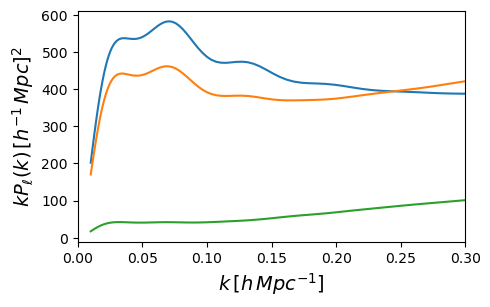

In [15]:
fig, axs = plt.subplots(figsize=(5,3))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(kh, kh * pkl0, label=r'$\ell = 0$')
axs.plot(kh, kh * pkl2, label=r'$\ell = 2$')
axs.plot(kh, kh * pkl4, label=r'$\ell = 4$')

axs.set_xlim([0, 0.3])
plt.show()


# Run Bispectrum in Sugiyama basis

In [17]:
# niusance parameters for the bispectrum
Pshot = 0; # This would be the same as PshopP*alphashot0 if the bispectrum were computed up to 1loop (I think!)
Bshot = 0;
c1,c2=0,0
X_FoG_bk=0

bisp_nuis_params = [b1, b2, bs2, c1,c2,Pshot,Bshot, X_FoG_bk]
OmM=(omega_cdm+omega_b+omega_ncdm)/h**2
bisp_cosmo_params = [z_pk,OmM,h]
FOLPS.f0_function(z_pk,OmM),OmM

(np.float64(0.7797171445808948), 0.3105814212519492)

In [18]:
k_ev = np.linspace(0.01,0.2, num = 40) 
k_ev_bk=np.vstack([k_ev,k_ev]).T   # List of pairs of k. (B=B(k1,k2))
precision=[10,10,10]

k1k2pairs=k_ev_bk

In [19]:
%%time
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
Bk = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params,
                     bisp_cosmo_params,qpar, qperp, k_pkl_pklnw,precision=[8,10,10], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='linear')

B000, B110, B220, B202,B022, B112 = Bk

CPU times: user 5.44 ms, sys: 2.06 ms, total: 7.49 ms
Wall time: 6.99 ms


Text(0.5, 1.0, 'B_l1l2L * H_l1l2L')

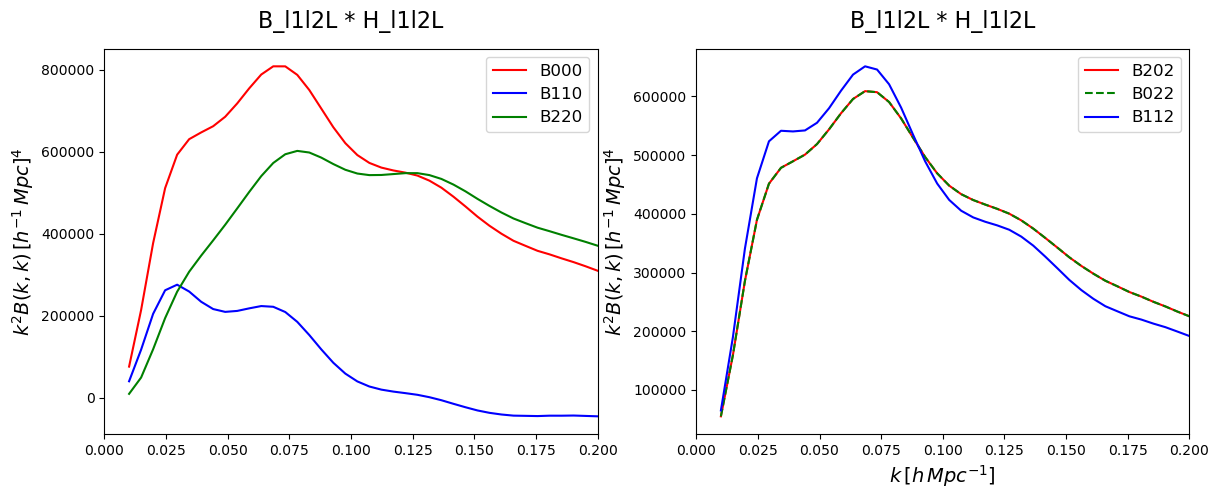

In [20]:
xmax=0.2

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[0].plot(k_ev, k_ev**2 * B000, label=r'B000', ls='-', color='red')
axs[0].plot(k_ev, k_ev**2 * B110, label=r'B110', ls='-', color='blue')
axs[0].plot(k_ev, k_ev**2 * B220, label=r'B220', ls='-', color='green')
axs[0].set_xlim([0, xmax])
axs[0].legend(fontsize=12, loc='best')
axs[0].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15)

axs[1].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=14)
axs[1].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[1].plot(k_ev, k_ev**2 * B202, label=r'B202', ls='-', color='red')
axs[1].plot(k_ev, k_ev**2 * B022, label=r'B022', ls='--', color='green')
axs[1].plot(k_ev, k_ev**2 * B112, label=r"B112", ls='-', color='blue')

axs[1].set_xlim([0, xmax])
axs[1].legend(fontsize=12, loc='best')
axs[1].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15)

In [21]:
# #Test with Mathematica

#### USE b1=1

# k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[0][1]]) #Without IR
# Bk = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params,
#                      bisp_cosmo_params,qpar, qperp, k_pkl_pklnw,precision=[8,10,10], 
#                      f=None, 
#                      renormalize=True, 
#                      interpolation_method='linear')

# B000, B110, B220, B202,B022, B112 = Bk

# k_m, B000_m, B110_m, B220_m, B202_m, B022_m, B112_m = np.loadtxt('Bl1l2L_mathematica.txt', unpack=True)

# xmax=0.2

# fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# axs[0].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
# axs[0].plot(k_ev, k_ev**2 * B000, label=r'B000', ls='-', color='red')
# axs[0].plot(k_ev, k_ev**2 * B000_m, label=r'B000 M', ls='--', color='red',lw=3)
# axs[0].plot(k_ev, k_ev**2 * B110, label=r'B110', ls='-', color='blue')
# axs[0].plot(k_ev, k_ev**2 * B110_m, label=r'B110 M', ls='--', color='blue',lw=3)
# axs[0].plot(k_ev, k_ev**2 * B220, label=r'B220', ls='-', color='green')
# axs[0].plot(k_ev, k_ev**2 * B220_m, label=r'B220 M', ls='--', color='green',lw=3)
# axs[0].set_xlim([0, xmax])
# axs[0].legend(fontsize=12, loc='best')
# axs[0].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15)

# axs[1].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=14)
# axs[1].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
# axs[1].plot(k_ev, k_ev**2 * B202, label=r'B202', ls='-', color='red')
# axs[1].plot(k_ev, k_ev**2 * B202_m, label=r'B202 M', ls='--', color='red',lw=3)
# axs[1].plot(k_ev, k_ev**2 * B022, label=r'B022  ', ls='-', color='green',lw=3)
# axs[1].plot(k_ev, k_ev**2 * B022_m, label=r'B022 M', ls='--', color='green',lw=3)
# axs[1].plot(k_ev, k_ev**2 * B112, label=r"B112", ls='-', color='blue')
# axs[1].plot(k_ev, k_ev**2 * B112_m, label=r'B112 M', ls='--', color='blue',lw=3)
# axs[1].set_xlim([0, xmax])
# axs[1].legend(fontsize=12, loc='best')
# axs[1].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15)

# Run 2D multipoles


In [23]:
def reconstruct_symmetric(Btri, Nk):
    i, j = np.tril_indices(Nk)
    B = np.zeros((Nk, Nk))
    B[i, j] = Btri
    B[j, i] = Btri
    return B


def reconstruct_B202_B022(B202_tri, B022_tri, Nk):
    i, j = np.tril_indices(Nk)

    B202 = np.zeros((Nk, Nk))
    B022 = np.zeros((Nk, Nk))

    # Lower triangle (direct)
    B202[i, j] = B202_tri
    B022[i, j] = B022_tri

    # Upper triangle (cross-fill)
    B202[j, i] = B022_tri
    B022[j, i] = B202_tri

    return B202, B022

In [24]:

k_ev = np.linspace(0.01, 0.2, num=20)
Nk = len(k_ev)

# LOWER triangular indices (k1 >= k2)
i, j = np.tril_indices(Nk)

k1k2pairs = np.column_stack((k_ev[i], k_ev[j]))

In [25]:
%%time
Bk2D = FOLPS.Sugiyama_Bl1l2L(k1k2pairs, bisp_nuis_params, bisp_cosmo_params, 
                     qpar, qperp, k_pkl_pklnw, 
                     precision=[8,10,10], 
                     f=None, 
                     renormalize=True, 
                     interpolation_method='linear')

B000_2D, B110_2D, B220_2D, B202_2D, B022_2D, B112_2D = Bk2D

B000_grid = reconstruct_symmetric(B000_2D, Nk)
B110_grid = reconstruct_symmetric(B110_2D, Nk)
B220_grid = reconstruct_symmetric(B220_2D, Nk)
B112_grid = reconstruct_symmetric(B112_2D, Nk)

B202_grid, B022_grid = reconstruct_B202_B022(
    B202_2D, B022_2D, Nk
)

CPU times: user 17.6 ms, sys: 4.68 ms, total: 22.3 ms
Wall time: 21.7 ms


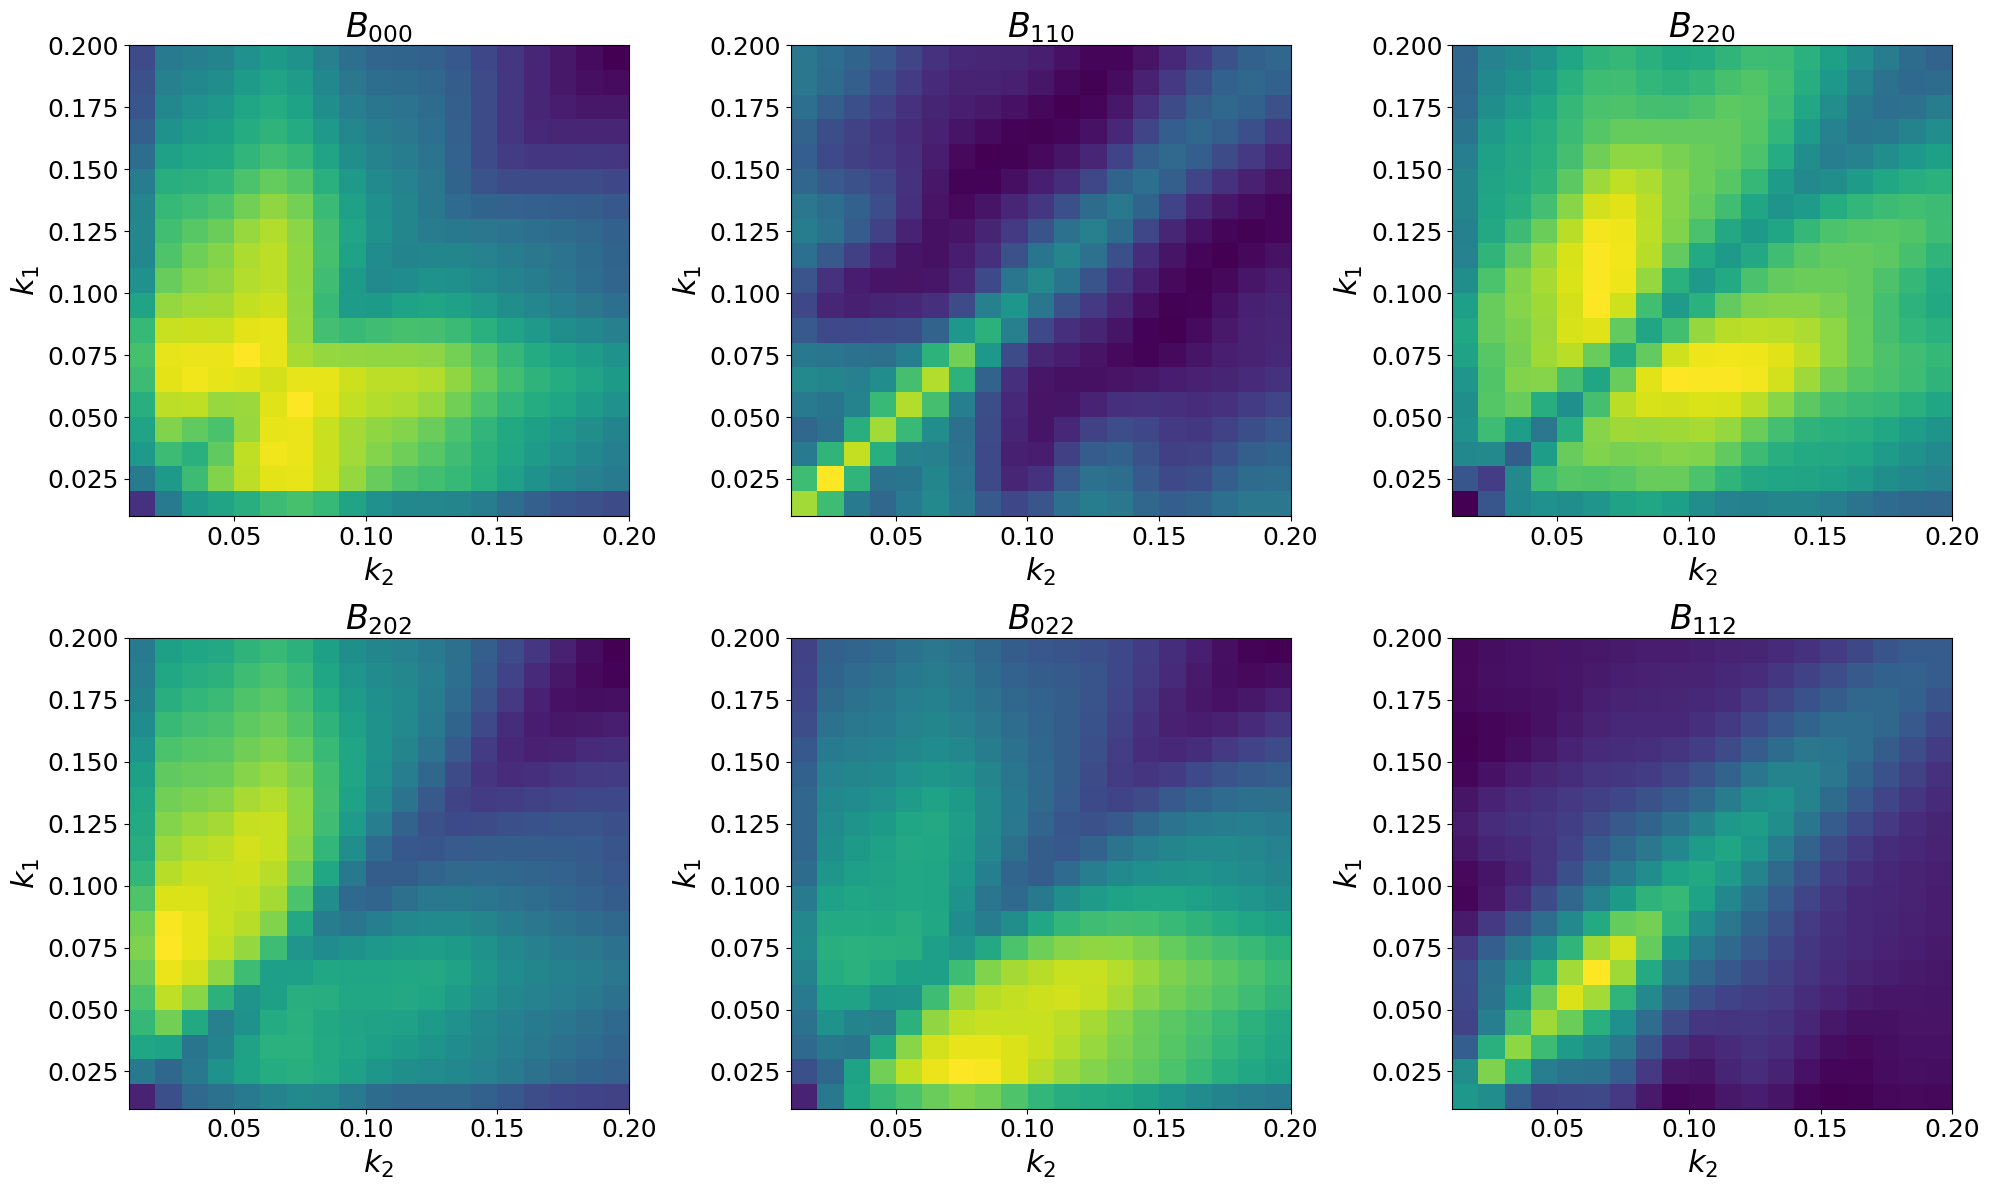

In [26]:
k1_vals = np.unique(k1k2pairs[:,0])
k2_vals = np.unique(k1k2pairs[:,1])

B000_scaled = B000_grid * k2_vals[:, None] * k1_vals[None, :]
B110_scaled = B110_grid * k2_vals[:, None] * k1_vals[None, :]
B220_scaled = B220_grid * k2_vals[:, None] * k1_vals[None, :]
B202_scaled = B202_grid * k2_vals[:, None] * k1_vals[None, :]
B022_scaled = B022_grid * k1_vals[:, None] * k2_vals[None, :]
B112_scaled = B112_grid * k2_vals[:, None] * k1_vals[None, :]

fig, axes = plt.subplots(2, 3, figsize=(20,12))

fs=24
fsk=22
fsl=18
showbar=False
# B000 imshow
im0 = axes[0,0].imshow(B000_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,0].set_title(r"$B_{000}$", fontsize=fs)
axes[0,0].set_xlabel("$k_2$", fontsize=fsk)
axes[0,0].set_ylabel("$k_1$", fontsize=fsk)
axes[0,0].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im0, ax=axes[0,0])

# B110 imshow
im1 = axes[0,1].imshow(B110_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,1].set_title(r"$B_{110}$", fontsize=fs)
axes[0,1].set_xlabel("$k_2$", fontsize=fsk)
axes[0,1].set_ylabel("$k_1$", fontsize=fsk)
axes[0,1].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im1, ax=axes[0,1])


# B110 imshow
im2 = axes[0,2].imshow(B220_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,2].set_title(r"$B_{220}$", fontsize=fs)
axes[0,2].set_xlabel("$k_2$", fontsize=fsk)
axes[0,2].set_ylabel("$k_1$", fontsize=fsk)
axes[0,2].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im3, ax=axes[0,2])

# B110 imshow
im2 = axes[1,0].imshow(B202_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,0].set_title(r"$B_{202}$", fontsize=fs)
axes[1,0].set_xlabel("$k_2$", fontsize=fsk)
axes[1,0].set_ylabel("$k_1$", fontsize=fsk)
axes[1,0].tick_params(axis='both', which='major', labelsize=fsl)

axes[1,0].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im2, ax=axes[1,0])





im3 = axes[1,1].imshow(B022_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,1].set_title(r"$B_{022}$", fontsize=fs)
axes[1,1].set_xlabel("$k_2$", fontsize=fsk)
axes[1,1].set_ylabel("$k_1$", fontsize=fsk)

axes[1,1].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im3, ax=axes[1,1])






im3 = axes[1,2].imshow(B112_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,2].set_title(r"$B_{112}$", fontsize=fs)
axes[1,2].set_xlabel("$k_2$", fontsize=fsk)
axes[1,2].set_ylabel("$k_1$", fontsize=fsk)
axes[1,2].tick_params(axis='both', which='major', labelsize=fsl)

if showbar:
    fig.colorbar(im3, ax=axes[1,2])



plt.tight_layout()
plt.show()


# Bispectrum Scoccimarro basis
Triangles are k1<k2<k3, and veck1 + veck2 + veck3 = 0.

Also, the angles in an equilateral triangle are 120 degrees, or hatk1.hatk2 = -0.5

In [28]:
k1T, k2T, k3T = np.loadtxt("k1k2k3.txt", unpack=True)
k1k2k3triplets = np.column_stack((k1T, k2T, k3T))

In [29]:
%%time
B0,B2,B4, xx=FOLPS.Bisp_Scoccimarro_all(bisp_cosmo_params, bisp_nuis_params, k_pkl_pklnw, 
                  k1k2k3triplets, qpar,qperp, f=None, precision=[10,10])

CPU times: user 64.1 ms, sys: 1.06 ms, total: 65.2 ms
Wall time: 64.7 ms


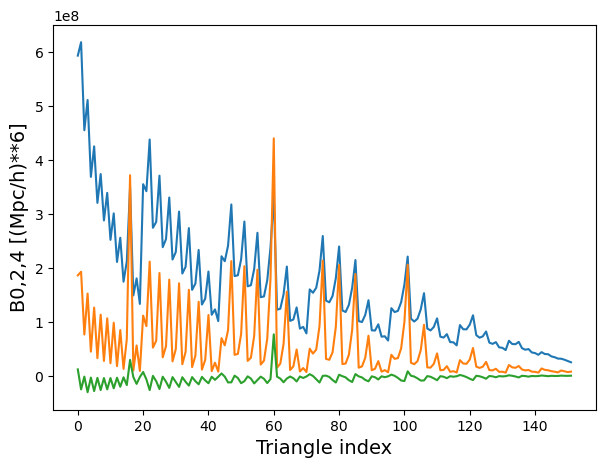

In [30]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'B0,2,4 [(Mpc/h)**6]', fontsize =  14)

# axs.plot(col2*col4*col6*B0/1, label=r'B0')

axs.plot(B0, label=r'B0')
axs.plot(B2, label=r'B0')
axs.plot(B4, label=r'B0')
# axs.plot(col2*col4*col6*B2/5, label=r'B0')

plt.show()

In [35]:
#extract equilateral and isosceles triangles
equilateral_n = []     
isosceles_n = []       

for i, (a, b, c) in enumerate(k1k2k3triplets):
    if a == b == c:
        equilateral_n.append(i)
    elif a == b or a == c or b == c:
        isosceles_n.append(i)
        
equilateral_n  = np.array(equilateral_n)    
isosceles_n = np.array(isosceles_n)

B0_equilateral=np.stack((equilateral_n, B0[equilateral_n]))
B0_isosceles=np.stack((isosceles_n, B0[isosceles_n]))


B2_equilateral=np.stack((equilateral_n, B2[equilateral_n]))
B2_isosceles=np.stack((isosceles_n, B2[isosceles_n]))

B4_equilateral=np.stack((equilateral_n, B4[equilateral_n]))
B4_isosceles=np.stack((isosceles_n, B4[isosceles_n]))

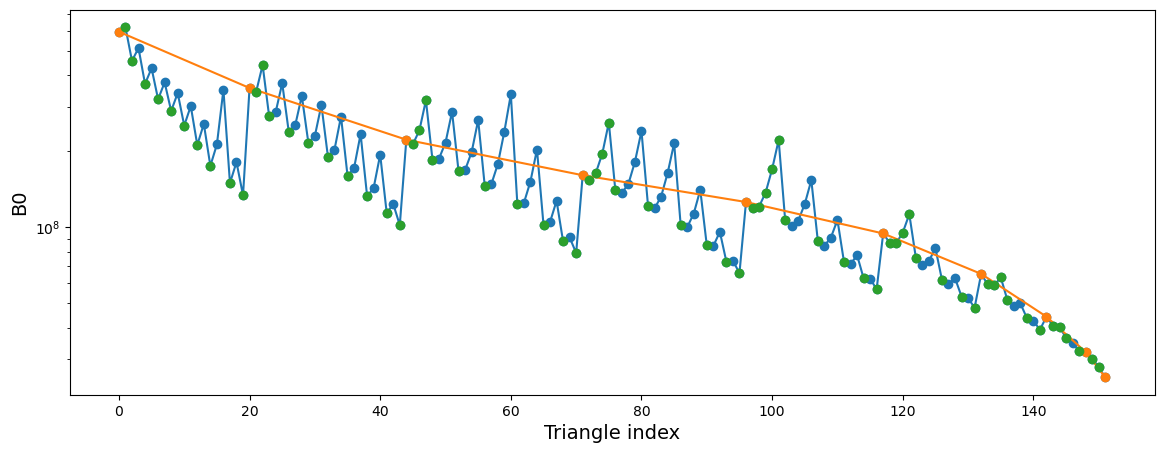

In [37]:
## check fig.2 of https://arxiv.org/pdf/1606.00439  CMASS NGC

fig, axs = plt.subplots(figsize=(14,5))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'B0', fontsize =  14)

x=np.arange(len(B0))
axs.semilogy(x,B0, 'o-')
axs.semilogy(B0_equilateral[0],B0_equilateral[1], 'o-')
axs.semilogy(B0_isosceles[0],B0_isosceles[1], 'o')

plt.show()

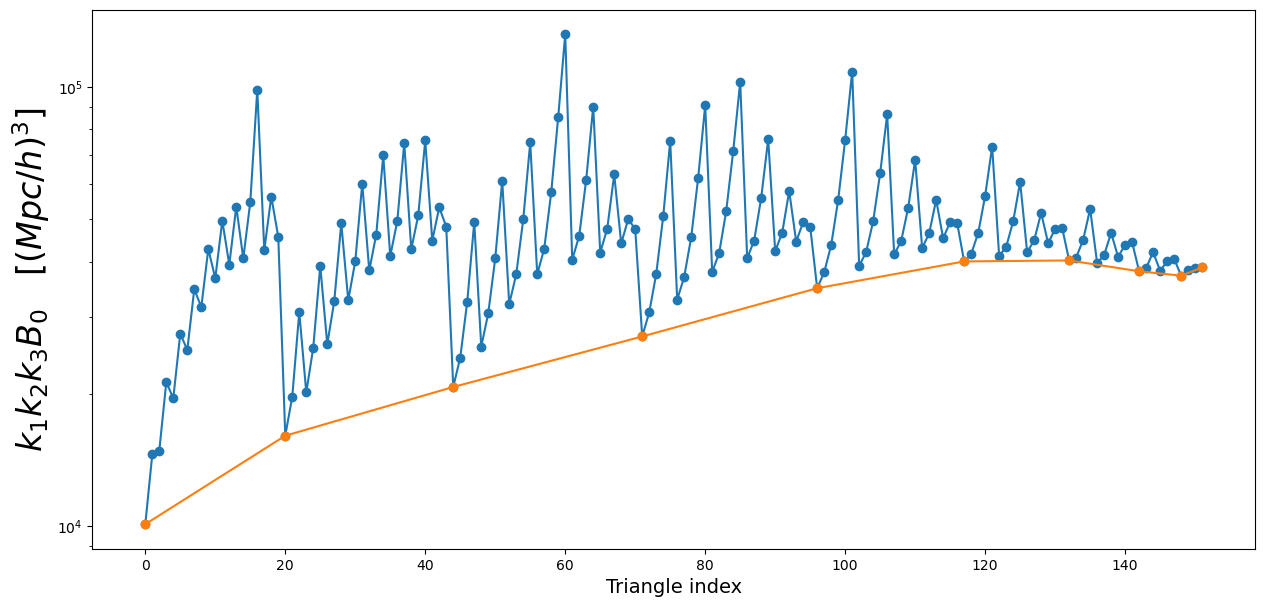

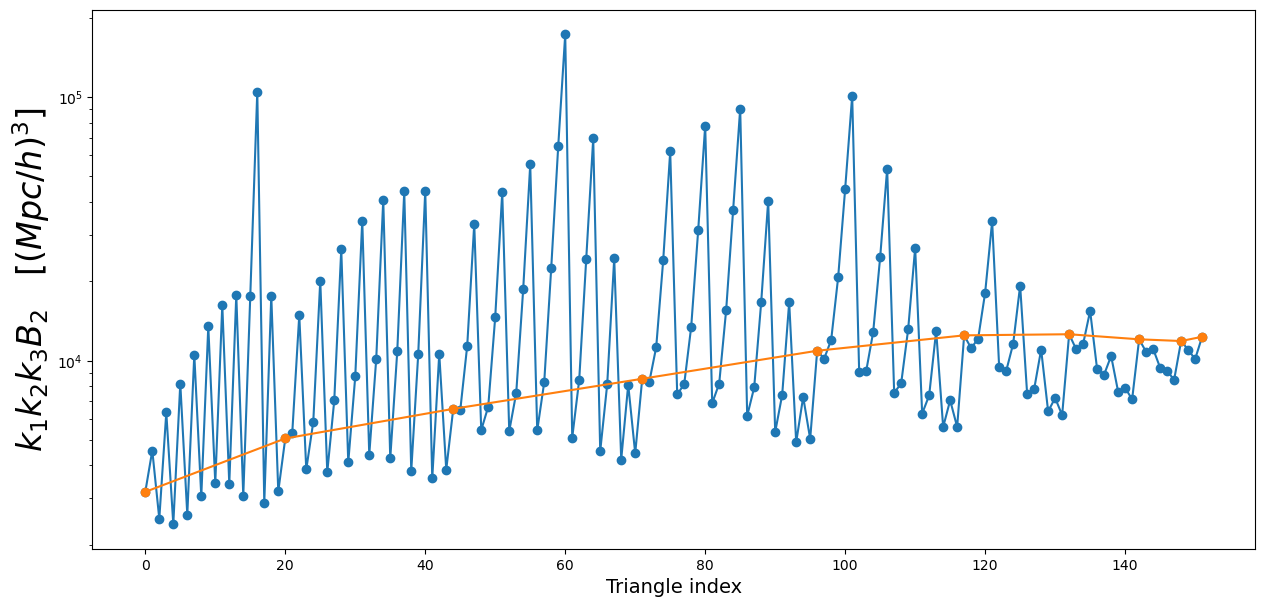

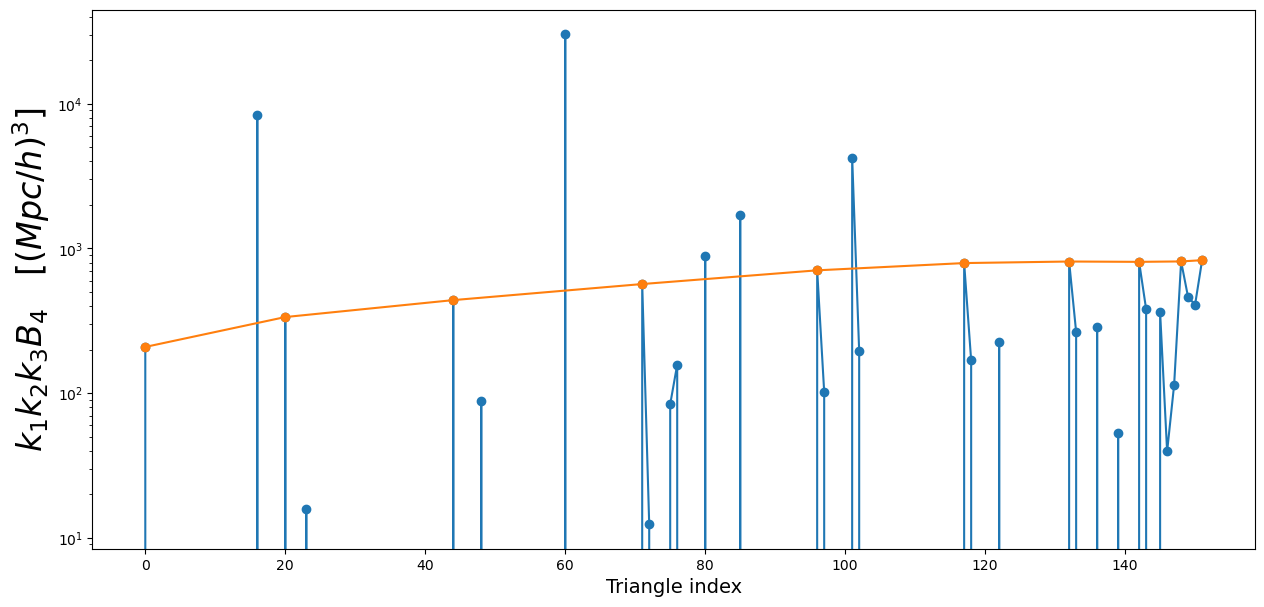

In [39]:

## check fig.2 of https://arxiv.org/pdf/2503.09714 (but her is a different cosmology)

x=np.arange(len(B0))
en=equilateral_n

fig, axs = plt.subplots(figsize=(15,7))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'$k_1 k_2k_3 B_0 \quad [(Mpc/h)^3]$', fontsize =  24)
axs.semilogy(x,k1T*k2T*k3T*B0, 'o-')
axs.semilogy(B0_equilateral[0],k1T[en]*k2T[en]*k3T[en]*B0_equilateral[1], 'o-')
plt.show()

fig, axs = plt.subplots(figsize=(15,7))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'$k_1 k_2k_3 B_2 \quad [(Mpc/h)^3]$', fontsize =  24)
x=np.arange(len(B0))
axs.semilogy(x,k1T*k2T*k3T*B2, 'o-')
axs.semilogy(B2_equilateral[0],k1T[en]*k2T[en]*k3T[en]*B2_equilateral[1], 'o-')
plt.show()

fig, axs = plt.subplots(figsize=(15,7))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'$k_1 k_2k_3 B_4 \quad [(Mpc/h)^3]$', fontsize =  24)
axs.semilogy(x,k1T*k2T*k3T*B4, 'o-')
axs.semilogy(B4_equilateral[0],k1T[en]*k2T[en]*k3T[en]*B4_equilateral[1], 'o-')

plt.show()